In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import pickle
import pandas as pd
import numpy as np
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier

/Users/peter.tung/enron-dataset-ml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
enron_df = pd.DataFrame.from_dict(data_dict, orient='index')
#We will remove email_address from the list of features as it does not have any value as a feature.
enron_df = enron_df.drop(['email_address'], axis = 1)

#There are two entries that are not really a person, so we should remove them.
enron_df = enron_df.drop(['TOTAL','THE TRAVEL AGENCY IN THE PARK'], axis = 0)

all_features = enron_df.columns.difference(['poi'])
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 
                      'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 
                      'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 
                      'restricted_stock', 'director_fees']
email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 
                  'from_this_person_to_poi', 'shared_receipt_with_poi']

#According to the project forum, financial data that have 'NaN' are actually '0' value 
#whereas email data that have 'NaN' are missing data.
for feature in financial_features:
    enron_df[feature] = enron_df[feature].replace('NaN', 0.0)
for feature in email_features:
    enron_df[feature] = enron_df[feature].replace('NaN', np.nan)
enron_df[all_features] = enron_df[all_features].apply(pd.to_numeric)

enron_features_df = enron_df[all_features].copy()

#remove all rows that are all 0.0/NaN
mask = np.all(np.isnan(enron_features_df) | np.equal(enron_features_df, 0), axis=1)
enron_df = enron_df[~mask]
enron_features_df = enron_df[all_features].copy()
enron_features_df.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000.000,2869717.000,-3081055.000,0.000,1729541.000,13868.000,2195.000,47.000,65.000,0.000,304805.000,152.000,126027.000,-126027.000,201955.000,1407.000,2902.000,4484442.000,1729541.000
BADUM JAMES P,0.000,178980.000,0.000,0.000,257817.000,3486.000,nan,nan,nan,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,182466.000,257817.000
BANNANTINE JAMES M,0.000,0.000,-5104.000,0.000,4046157.000,56301.000,29.000,39.000,0.000,0.000,0.000,864523.000,1757552.000,-560222.000,477.000,465.000,566.000,916197.000,5243487.000
BAXTER JOHN C,1200000.000,1295738.000,-1386055.000,0.000,6680544.000,11200.000,nan,nan,nan,0.000,1586055.000,2660303.000,3942714.000,0.000,267102.000,nan,nan,5634343.000,10623258.000
BAY FRANKLIN R,400000.000,260455.000,-201641.000,0.000,0.000,129142.000,nan,nan,nan,0.000,0.000,69.000,145796.000,-82782.000,239671.000,nan,nan,827696.000,63014.000


In [4]:
enron_features_df.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,143.000,143.000,143.000,143.000,143.000,143.000,86.000,86.000,86.000,143.000,143.000,143.000,143.000,143.000,143.000,86.000,86.000,143.000,143.000
mean,680724.608,223642.629,-195037.699,10050.112,2090318.077,35622.720,608.791,64.895,41.233,586888.112,339314.182,296806.692,874609.972,73931.315,186742.860,1176.465,2073.860,2272322.587,2930133.762
std,1236179.688,756520.789,607922.475,31399.349,4809193.249,45370.870,1841.034,86.979,100.073,6818177.362,689013.933,1135030.646,2022338.365,1306545.168,197117.072,1178.318,2582.701,8876252.372,6205936.524
min,0.000,-102500.000,-3504386.000,0.000,0.000,0.000,12.000,0.000,0.000,0.000,0.000,0.000,-2604490.000,-1787380.000,0.000,2.000,57.000,0.000,-44093.000
25%,0.000,0.000,-37506.000,0.000,0.000,0.000,22.750,10.000,1.000,0.000,0.000,0.000,38276.500,0.000,0.000,249.750,541.250,96796.500,254936.000
50%,300000.000,0.000,0.000,0.000,608750.000,21530.000,41.000,35.000,8.000,0.000,0.000,947.000,360528.000,0.000,210692.000,740.500,1211.000,966522.000,976037.000
75%,800000.000,9110.000,0.000,0.000,1698900.500,53534.500,145.500,72.250,24.750,0.000,374825.500,149204.000,775992.000,0.000,270259.000,1888.250,2634.750,1956977.500,2307583.500
max,8000000.000,6426990.000,0.000,137864.000,34348384.000,228763.000,14368.000,528.000,609.000,81525000.000,5145434.000,10359729.000,14761694.000,15456290.000,1111258.000,5521.000,15149.000,103559793.000,49110078.000


In [5]:
print "poi's: {}".format(len(enron_df[enron_df['poi'] == True]))
print "non-poi's {}".format(len(enron_df[enron_df['poi'] == False]))
enron_features_df.shape

poi's: 18
non-poi's 125


(143, 19)

Populating the interactive namespace from numpy and matplotlib


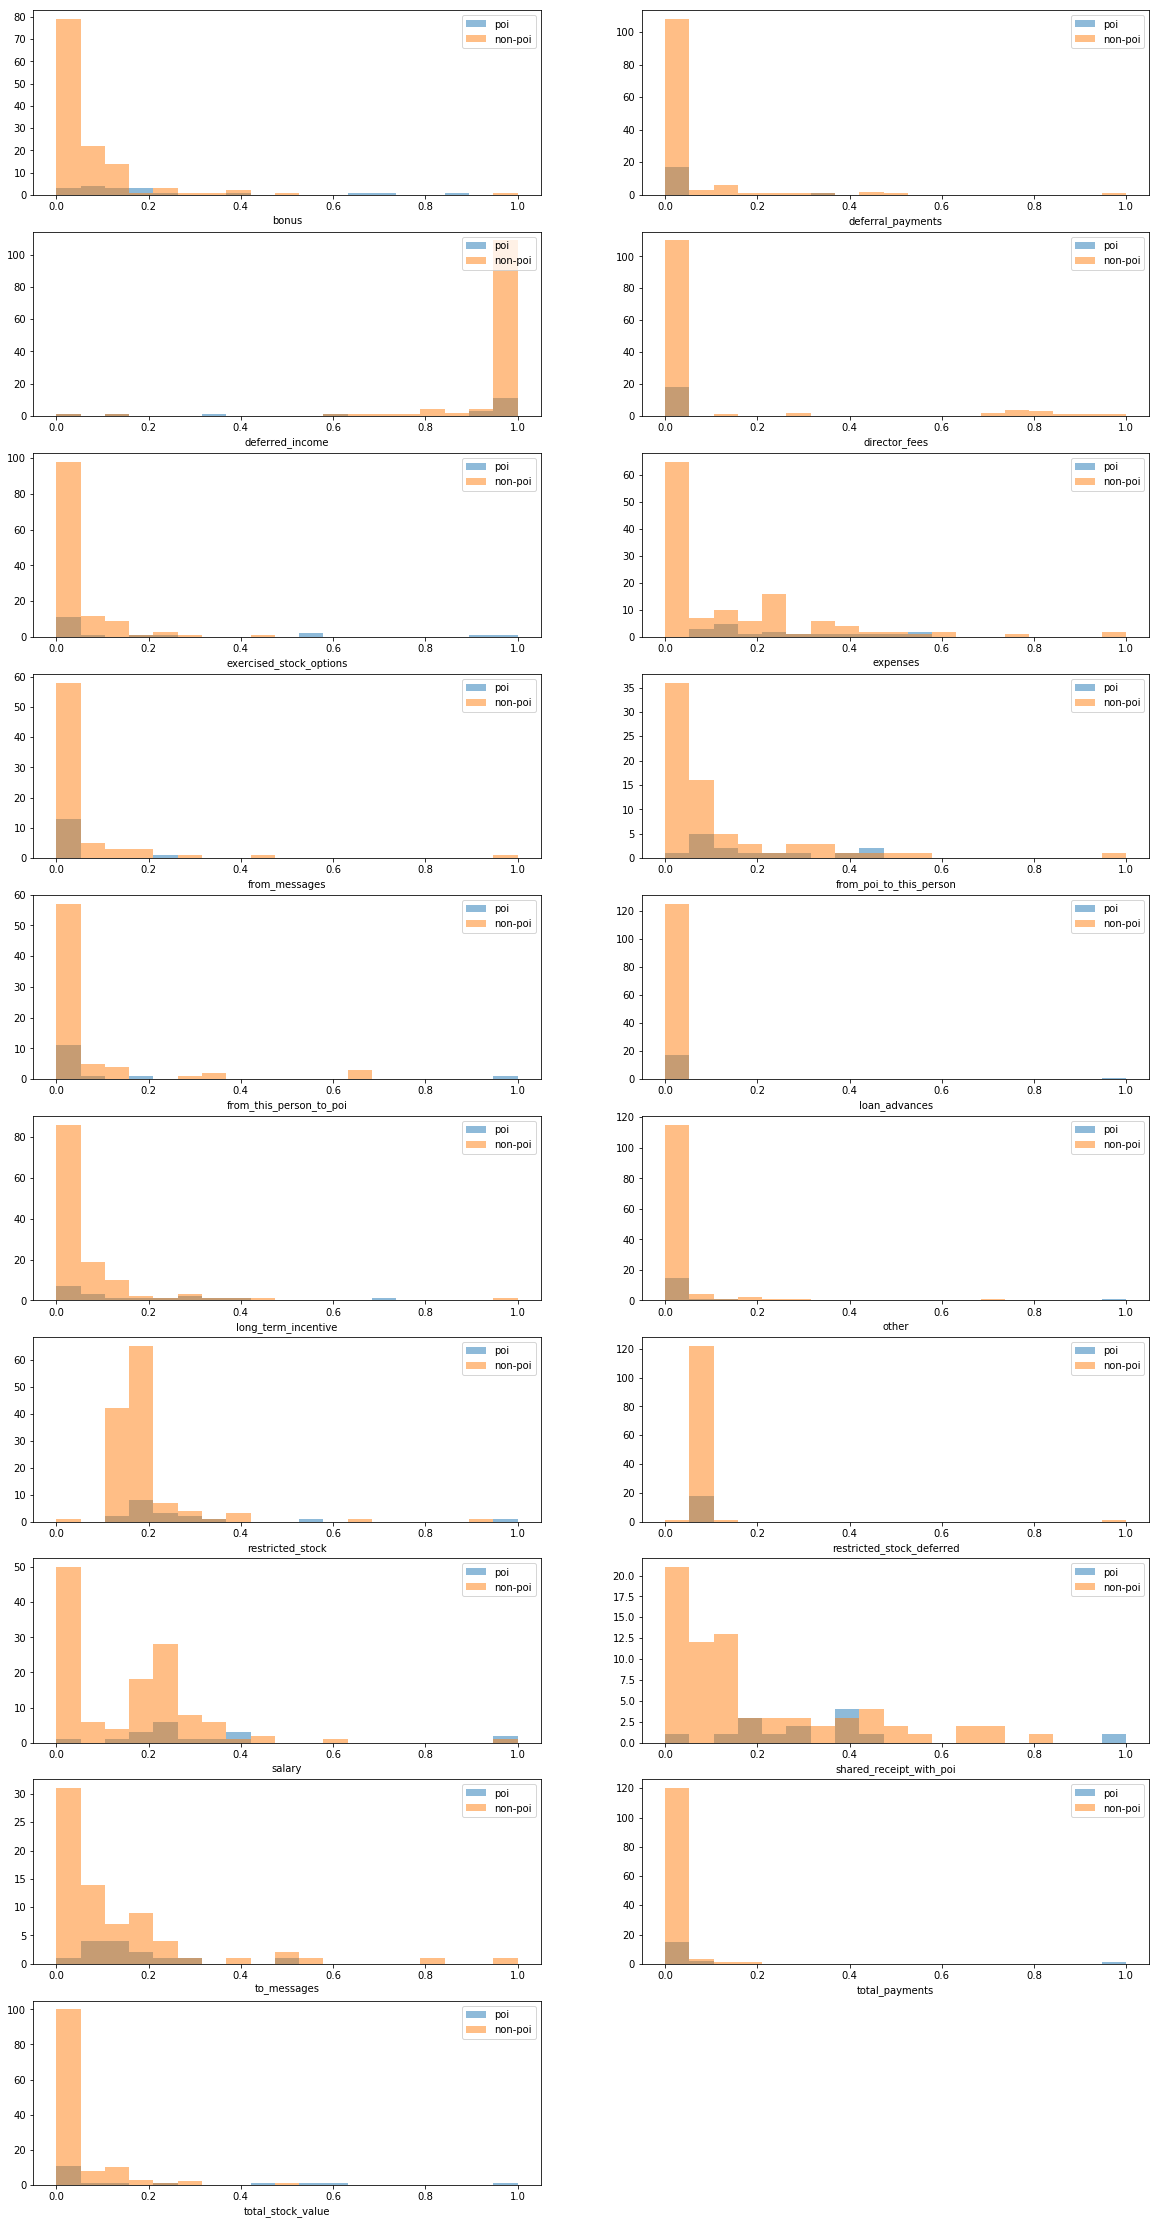

In [6]:
#We see some features like director_fees, and loan_advances have very little data.  It's likely that
#these features will not have much value, but let's look through all the data first.
import matplotlib.pyplot as plt
from sklearn import preprocessing
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 40)

min_max_scaler = preprocessing.MinMaxScaler()
subplot = 1
bins = numpy.linspace(0, 1, 20)
for feature in all_features:
    plt.subplot(10, 2, subplot)
    #we'll drop the nan values for now
    sub_df = enron_df[[feature, 'poi']].dropna()
    #we'll scale the date with a min/max scaler so we can overlap the poi vs non poi histograms 
    #using bins of the same size
    sub_df[feature] = min_max_scaler.fit_transform(sub_df[feature].reshape(-1, 1))
    poi_df = sub_df.query('poi == True')
    non_poi_df = sub_df.query('poi == False')
    if poi_df.shape[0] > 0: plt.hist(poi_df[feature], bins, alpha=0.5, label='poi')
    if non_poi_df.shape[0] > 0: plt.hist(non_poi_df[feature], bins, alpha=0.5, label='non-poi')
    plt.legend(loc='upper right')
    plt.xlabel(feature)
    subplot = subplot + 1
plt.show()
#sub_df.head()

The histograms and the summaries tells us that some features cannot be used in our prediction model as it only contain information for non-poi's. We will remove `director_fees` and `restricted_stock_deferred` from the list of features.
In addition `loan_advances` only has 3 non zero data points so we will remove that feature as well.  
The distribution of many of remaining features also look very skewed. For example, `total_payments` have most of the data on the left side of the graph suggesting that there are possible outliers.

In [64]:
#Let's take a quick look at the nan entries to see if they provide any additional information
sub_df = None
all_features = enron_df.columns.difference(['poi'])
for feature in all_features:
    sub_df_nan = enron_df[pd.isnull(enron_df[feature])][['poi']]
    sub_df_zero = enron_df[enron_df[feature] == 0][['poi']]
    if len(sub_df_nan) > 0:
        print '{} NaN: {} of {}'.format(feature,
                                        len(sub_df_nan[sub_df_nan['poi'] == True]),
                                        len(sub_df_nan))
    if len(sub_df_zero) > 0:
        print '{} zero: {} of {}'.format(feature, 
                                         len(sub_df_zero[sub_df_zero['poi'] == True]), 
                                         len(sub_df_zero))

bonus zero: 2 of 62
deferral_payments zero: 13 of 105
deferred_income zero: 7 of 95
director_fees zero: 18 of 127
exercised_stock_options zero: 6 of 42
expenses zero: 0 of 49
from_messages NaN: 4 of 57
from_poi_to_this_person NaN: 4 of 57
from_poi_to_this_person zero: 0 of 12
from_this_person_to_poi NaN: 4 of 57
from_this_person_to_poi zero: 0 of 20
loan_advances zero: 17 of 140
long_term_incentive zero: 6 of 78
other zero: 0 of 52
restricted_stock zero: 1 of 34
restricted_stock_deferred zero: 18 of 126
salary zero: 1 of 49
shared_receipt_with_poi NaN: 4 of 57
to_messages NaN: 4 of 57
total_payments zero: 0 of 20
total_stock_value zero: 0 of 18


In [7]:
remove_features = ['director_fees', 'restricted_stock_deferred', 'loan_advances']
enron_removed_df = enron_df.drop(remove_features, axis = 1)

4 of 57 of the nan values are poi's, which accounts for ~23% of all pois.  
53 of 57 of the nan values are non-poi's, which accounts for ~42% of all non pois.  
Given the small dataset, it might be useful to assign values to this entries.

In [9]:
for feature in email_features:
    enron_removed_df[feature] = enron_removed_df[feature].replace(np.nan, 0.0)

In [10]:
enron_features_removed_df = enron_removed_df.drop(['poi'], axis = 1)
enron_features_removed_df.corr()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,deferred_income,long_term_incentive,from_poi_to_this_person
salary,1.000,0.395,0.242,0.511,0.449,0.649,0.538,0.510,0.521,0.358,0.143,0.545,0.206,-0.329,0.559,0.406
to_messages,0.395,1.000,0.124,0.197,0.084,0.519,0.159,0.881,0.117,0.241,0.508,0.106,0.605,-0.121,0.191,0.618
deferral_payments,0.242,0.124,1.000,0.141,0.117,0.174,0.088,0.210,0.118,-0.022,0.029,0.369,0.002,-0.543,0.119,0.216
total_payments,0.511,0.197,0.141,1.000,0.599,0.560,0.604,0.254,0.661,0.151,0.009,0.830,0.062,-0.103,0.520,0.215
exercised_stock_options,0.449,0.084,0.117,0.599,1.000,0.416,0.587,0.125,0.964,0.121,-0.024,0.551,0.002,-0.268,0.399,0.125
bonus,0.649,0.519,0.174,0.560,0.416,1.000,0.423,0.664,0.461,0.244,0.174,0.383,0.448,-0.331,0.497,0.640
restricted_stock,0.538,0.159,0.088,0.604,0.587,0.423,1.000,0.180,0.780,0.180,0.022,0.635,0.059,-0.126,0.342,0.125
shared_receipt_with_poi,0.510,0.881,0.210,0.254,0.125,0.664,0.180,1.000,0.155,0.285,0.301,0.180,0.524,-0.236,0.278,0.732
total_stock_value,0.521,0.117,0.118,0.661,0.964,0.461,0.780,0.155,1.000,0.151,-0.012,0.634,0.021,-0.244,0.421,0.137
expenses,0.358,0.241,-0.022,0.151,0.121,0.244,0.180,0.285,0.151,1.000,0.155,0.138,0.133,-0.040,0.095,0.146


In [62]:
#drop nan
enron_cleaned_df = enron_removed_df.dropna()
print enron_cleaned_df.shape

(143, 17)


### Baseline
Let's use all the features to see what kind of results we get.

In [12]:

features = enron_cleaned_df.drop(['poi'], axis = 1)
labels = enron_cleaned_df[['poi']]

data_dict = enron_cleaned_df.to_dict('index')
columns = ['poi'] + list(features)

#split data
from sklearn.cross_validation import StratifiedShuffleSplit, train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    features.values, labels.values, test_size=0.3, random_state=42, stratify=labels.values)

#train logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)

test_classifier(clf, data_dict, columns)

#train random forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_train, y_train)
test_classifier(rf_clf, data_dict, columns)

#train svm
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(min_max_scaler.fit_transform(X_train), y_train)
test_classifier(svm_clf, data_dict, columns)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
	Accuracy: 0.71933	Precision: 0.11337	Recall: 0.16200	F1: 0.13339	F2: 0.14920
	Total predictions: 15000	True positives:  324	False positives: 2534	False negatives: 1676	True negatives: 10466

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
	Accuracy: 0.85540	Precision: 0.37331	Recall: 0.12450	F1: 0.18673	F2: 0.14365
	Total predictions: 15000	True positives:  249	False positives:  418	False negatives

Without any feature engineering, feature selection, and parameter tuning, it looks like the random forest classifier was the most accurate with higher precision (but lower recall).  SVM does not seem to be able to make proper predictions without further tuning.

In [13]:
#Feature engineering
#The easiest one would be a bonus salary ratio, people with high bonuses in comparison 
#to their salaries could be suspect
enron_eng_df = enron_cleaned_df.copy()
enron_eng_df['bonus_salary_ratio'] = enron_eng_df['bonus'] / (enron_eng_df['salary'] + 1)

#stocks to salary ratio could also be an indicator, specifically the exercised_stock_options where poi's knowingly
#sell their shares at a high before the stock value plummetted.
enron_eng_df['exercised_stock_salary_ratio'] = enron_eng_df['exercised_stock_options'] / \
    (enron_eng_df['salary'] + 1)
    
enron_eng_df = enron_eng_df.dropna()
features = enron_eng_df.drop(['poi'], axis = 1)
labels = enron_eng_df[['poi']]

data_dict = enron_eng_df.to_dict('index')
columns = ['poi'] + list(features)

#X_train, X_test, y_train, y_test = train_test_split(
#    features.values, labels.values, test_size=0.3, random_state=42, stratify=labels)

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import classification_report
#We will use an automatic feature selection method and apply it to logistic regression 
#To find the best value for K, we will also employ a gridsearch
#In addition, we will tune the regularization parameter for logistic regression
sss = StratifiedShuffleSplit(labels.values, 100, random_state = 42)
kbest = SelectKBest(f_classif)
pipeline = Pipeline([('kbest', kbest), ('lr', LogisticRegression())])
grid_search_lr = GridSearchCV(pipeline, {'kbest__k': np.arange(1, len(X_train[0]) + 1),
                                      'lr__C': np.logspace(-2, 2, 10)},
                              scoring="f1", cv = sss, n_jobs = 4)
grid_search_lr.fit(features, np.reshape(labels.values,[len(labels.values),]))

#y_pred = grid_search_lr.predict(X_test)

#print classification_report(y_test, y_pred)
print grid_search_lr.best_estimator_.get_params()

{'lr__verbose': 0, 'lr__dual': False, 'lr__solver': 'liblinear', 'lr__multi_class': 'ovr', 'lr__n_jobs': 1, 'lr__penalty': 'l2', 'lr__max_iter': 100, 'lr__random_state': None, 'kbest__score_func': <function f_classif at 0x105125578>, 'lr': LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'kbest__k': 15, 'lr__fit_intercept': True, 'kbest': SelectKBest(k=15, score_func=<function f_classif at 0x105125578>), 'lr__intercept_scaling': 1, 'lr__class_weight': None, 'steps': [('kbest', SelectKBest(k=15, score_func=<function f_classif at 0x105125578>)), ('lr', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001

In [20]:
clf_lr = grid_search_lr.best_estimator_
test_classifier(clf_lr, data_dict, columns)

Pipeline(steps=[('kbest', SelectKBest(k=15, score_func=<function f_classif at 0x105125578>)), ('lr', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
	Accuracy: 0.70913	Precision: 0.10890	Recall: 0.16450	F1: 0.13105	F2: 0.14926
	Total predictions: 15000	True positives:  329	False positives: 2692	False negatives: 1671	True negatives: 10308



In [45]:
#For SVM we will employ a similar method
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
combined_features = FeatureUnion([("pca", PCA()), ("kbest", kbest)])
pipeline = Pipeline([('scale', preprocessing.MinMaxScaler(feature_range=(0, 1))),
                     ('features', combined_features),
                     ('svm', SVC())])
grid_search_svm = GridSearchCV(pipeline, {'features__kbest__k': np.arange(5, len(X_train[0]) + 1),
                                          'features__pca__n_components': np.arange(2,15),
                                          'svm__C': np.logspace(-2, 2, 5),
                                          'svm__gamma': np.logspace(-4, -1, 10),
                                          'svm__kernel': ['linear', 'rbf']},
                              scoring="f1", cv = sss)
grid_search_svm.fit(X_train, np.reshape(y_train,[len(y_train),]))
y_pred = grid_search_svm.predict(X_test)

print classification_report(y_test, y_pred)
print grid_search_svm.best_estimator_.get_params()

clf_svm = grid_search_svm.best_estimator_
test_classifier(clf_svm, data_dict, columns)

             precision    recall  f1-score   support

      False       0.88      1.00      0.94        38
       True       0.00      0.00      0.00         5

avg / total       0.78      0.88      0.83        43

{'features': FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('kbest', SelectKBest(k=6, score_func=<function f_classif at 0x7f99afa2dcf8>))],
       transformer_weights=None), 'svm__coef0': 0.0, 'features__pca__copy': True, 'svm__shrinking': True, 'svm__gamma': 0.046415888336127774, 'svm__verbose': False, 'svm__probability': False, 'features__pca__whiten': False, 'features__kbest__k': 6, 'features__kbest': SelectKBest(k=6, score_func=<function f_classif at 0x7f99afa2dcf8>), 'scale__copy': True, 'features__kbest__score_func': <function f_classif at 0x7f99afa2dcf8>, 'features__n_jobs': 1, 'svm__cache_size': 200, 'scale': MinMaxScaler(copy=True, featur

In [25]:
#For RandomForest
sss = StratifiedShuffleSplit(labels.values, 100, random_state = 42)
pipeline = Pipeline([('kbest', kbest), ('rf', RandomForestClassifier(random_state = 42))])
grid_search_rf = GridSearchCV(pipeline, {'kbest__k': np.arange(5, len(X_train[0]) + 1),
                                         'rf__n_estimators': np.arange(10, 20),
                                         #'rf__max_features': ['sqrt', 'log2', None],
                                         'rf__min_samples_split': np.arange(2,6)
                                        },
                             scoring="f1", cv = sss, n_jobs = 4)
grid_search_rf.fit(features.values, np.reshape(labels.values,[len(labels.values),]))

GridSearchCV(cv=StratifiedShuffleSplit(labels=[[False]
 [False]
 ...,
 [ True]
 [False]], n_iter=100, test_size=0.1, random_state=42),
       error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x105125578>)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'kbest__k': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'rf__min_samples_split': array([2, 3, 4, 5]), 'rf__n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [26]:
clf_rf = grid_search_rf.best_estimator_
test_classifier(clf_rf, data_dict, columns)

Pipeline(steps=[('kbest', SelectKBest(k=5, score_func=<function f_classif at 0x105125578>)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=19, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])
	Accuracy: 0.85927	Precision: 0.44308	Recall: 0.21600	F1: 0.29042	F2: 0.24067
	Total predictions: 15000	True positives:  432	False positives:  543	False negatives: 1568	True negatives: 12457



Still not good enough...  
Let's try something simpler

In [39]:
from sklearn.tree import DecisionTreeClassifier
pipeline = Pipeline([('kbest', kbest), ('dt', DecisionTreeClassifier(random_state = 42))])
grid_search_dt = GridSearchCV(pipeline, {'kbest__k': np.arange(1, len(X_train[0]) + 1),
                                         'dt__min_samples_split': np.arange(2,10),
                                         'dt__max_depth': [None, 2, 4, 6, 10],
                                         'dt__min_samples_leaf': np.arange(1,5),
                                         'dt__max_leaf_nodes': [None, 2, 4, 6, 10, 20]
                                        },
                             scoring="f1", cv = sss, n_jobs = 4)
grid_search_dt.fit(features.values, np.reshape(labels.values,[len(labels.values),]))

GridSearchCV(cv=StratifiedShuffleSplit(labels=[[False]
 [False]
 ...,
 [ True]
 [False]], n_iter=100, test_size=0.1, random_state=42),
       error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x105125578>)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'dt__max_leaf_nodes': [None, 2, 4, 6, 10, 20], 'kbest__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'dt__max_depth': [None, 2, 4, 6, 10], 'dt__min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]), 'dt__min_samples_leaf': array([1, 2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [40]:
clf_dt = grid_search_dt.best_estimator_
test_classifier(clf_dt, data_dict, columns)

Pipeline(steps=[('kbest', SelectKBest(k=3, score_func=<function f_classif at 0x105125578>)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=20, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])
	Accuracy: 0.81960	Precision: 0.32831	Recall: 0.33750	F1: 0.33284	F2: 0.33562
	Total predictions: 15000	True positives:  675	False positives: 1381	False negatives: 1325	True negatives: 11619



Oddly enough, the simplier tree model performed better.  Let's extract the relvant parameters.

In [44]:
grid_search_dt.best_params_

{'dt__max_depth': 6,
 'dt__max_leaf_nodes': 20,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'kbest__k': 3}

In [59]:
features_selected_bool = grid_search_dt.best_estimator_.named_steps['kbest'].get_support()
features_scores = grid_search_dt.best_estimator_.named_steps['kbest'].scores_
print "Selected Features:"
print [x for x, y in zip(columns[1:], features_selected_bool) if y]
print ""
print "Feature Scores:"
print [x for x, y in zip(features_scores, features_selected_bool) if y]
print ""
print "Feature Importances:"
print grid_search_dt.best_estimator_.named_steps['dt'].feature_importances_

Selected Features:
['salary', 'exercised_stock_options', 'total_stock_value']

Feature Scores:
[11.196268305382178, 13.714021288571223, 14.691308652557387]

Feature Importances:
[ 0.36992115  0.37653718  0.25354167]


In [58]:
#Our final model score:
final_features_list = ['poi', 'salary', 'exercised_stock_options', 'total_stock_value']
final_clf = DecisionTreeClassifier(random_state = 42,
                                   max_depth = 6,
                                   max_leaf_nodes = 20,
                                   min_samples_leaf = 1,
                                   min_samples_split = 2)
test_classifier(final_clf, data_dict, final_features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=20, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
	Accuracy: 0.82015	Precision: 0.40035	Recall: 0.33950	F1: 0.36742	F2: 0.35014
	Total predictions: 13000	True positives:  679	False positives: 1017	False negatives: 1321	True negatives: 9983



In [61]:
#What happened to our engineered features?
final_features_eng_list = final_features_list + ['exercised_stock_salary_ratio']
test_classifier(final_clf, data_dict, final_features_eng_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=20, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
	Accuracy: 0.80138	Precision: 0.33428	Recall: 0.29350	F1: 0.31257	F2: 0.30084
	Total predictions: 13000	True positives:  587	False positives: 1169	False negatives: 1413	True negatives: 9831



In [65]:
np.arange(2,10)

array([2, 3, 4, 5, 6, 7, 8, 9])